<a href="https://colab.research.google.com/github/Krankile/ensemble-forecasting/blob/main/lstm_vae_m4_interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
%%capture
!pip install wandb --upgrade

import wandb

wandb.login()

In [2]:
import os
import copy
import random
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn

plt.rcParams["figure.figsize"] = (16, 8)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [4]:
if not os.path.exists("modelsaves"):
    os.makedirs("modelsaves")

In [5]:
optimizers = {
    "adam": torch.optim.Adam,
    "sgd": torch.optim.SGD,
    "adamw": torch.optim.AdamW,
}

## Define models

In [6]:
class Encoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim, hidden_dim, dropout1, dropout2):
        super(Encoder, self).__init__()

        self.seq_len = seq_len
        self.n_features = n_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        self.rnn1 = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )

        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )

        self.dropout1 = nn.Dropout(p=dropout1, inplace=False)
        self.dropout2 = nn.Dropout(p=dropout2, inplace=False)

    def forward(self, x):
        x = self.dropout1(x)
        x, (_, _) = self.rnn1(x)
        x = self.dropout2(x)
        x, (hidden_n, _) = self.rnn2(x)

        return hidden_n.reshape((-1, self.n_features, self.embedding_dim))

In [7]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim, hidden_dim, n_features):
    super(Decoder, self).__init__()

    self.seq_len = seq_len
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.n_features = n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(1, self.seq_len, 1)

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((-1, self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [8]:
class RecurrentAutoencoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim, hidden_dim, dropout1, dropout2):
        super(RecurrentAutoencoder, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim, hidden_dim, dropout1, dropout2).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, hidden_dim, n_features).to(device)

    def forward(self, x):

        x = self.encoder(x)
        x = self.decoder(x)

        return x

## Define data functions

In [9]:
class M4Monthly(Dataset):
    def __init__(self, filepath, n_series=None):
        self.series = pd.read_feather(filepath).set_index("Name").astype("float32")

        self.shape = self.series.shape + (1, )

        if n_series:
            self.series = self.series.sample(n=n_series, replace=False)

    def __len__(self):
        return len(self.series)

    def __getitem__(self, idx):
        return self.series.iloc[idx, :].to_numpy().reshape(self.shape[1:])

In [10]:
def get_dataloaders(run, path=None):
    if path:
        artifact_path = path    
    else:
        artifact_path = "/content/artifacts/m4-month-40:v3/m4-month-40.feather"

    # Query W&B for an artifact and mark it as input to this run
    conf = run.config
    # artifact = run.use_artifact(conf.dataartifact)
    # Download the artifact's contents
    # artifact_path = artifact.get_path(f"{conf.dataartifact.split(':')[0]}.feather").download()
    # artifact_path = artifact_path if len(artifact_path) > 1 else defpath

    m4dataset = M4Monthly(artifact_path, n_series=conf.n_series)
    l = len(m4dataset)
    split = (l - l // 10, l // 10)
    train_data, val_data = random_split(m4dataset, lengths=split)

    train_loader = DataLoader(train_data, batch_size=conf.batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=conf.batch_size, shuffle=True)

    seq_len, num_features = m4dataset.shape[1:]

    return train_loader, val_loader, seq_len, num_features

## Define plotting functions

In [11]:
def plot(ax, d1, d2, idx):
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.plot(d1, label=f'Original')
    ax.plot(d2, label=f'Reconstructed')
    ax.legend()

def plot_examples(figurepath,
                  data1,
                  data2,
                  epoch,
                  conf,
                  rows=3,
                  cols=3,
                  size=(16, 8),
                  show=False,):
    plt.style.use('seaborn-pastel')
    figs = np.array(range(rows*cols)).reshape((rows, cols))
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=size)
    meta = {
        "epoch": epoch,
        "ed": conf.embedding_dim,
        "hd": conf.hidden_dim,
        "d2": conf.dropout2,
        "opt": conf.optimizer,
        "batch": conf.batch_size,
    }
    
    fig.suptitle(f"Results on val data ({meta})", size=14)

    idx = 0

    for rfig, rdat in zip(axs, figs):
        for ax, r in zip(rfig, rdat):
            plot(ax, data1[r], data2[r], idx=idx)
            idx += 1

    fig.tight_layout()
    fig.subplots_adjust(top=0.92)
    
    plt.savefig(figurepath)
    if not show:
        plt.close(fig)

## Define training helper functions

In [12]:
def early_stop(hi, ma1=5, ma2=20, em=1.05):
    val_ma1 = np.mean(hi["val"][-ma1:])
    val_ma2 = np.mean(hi["val"][-ma2:])*em
    
    if val_ma2 < val_ma1 and hi["val"][-1] > hi["train"][-1]:
        return True

    return False

## Define training loop

In [13]:
def train_model(model, train_loader, val_loader, conf):

    optimizer = optimizers[conf.optimizer](model.parameters(), lr=conf.learning_rate)
    criterion = nn.L1Loss(reduction="mean").to(device)

    # Test with sMAPE and MASE as well maybe
    wandb.watch(model, criterion, log="all", log_freq=1)

    best_loss = float("inf")
    b_size = conf.batch_size
    step = 0
    example_data = next(iter(val_loader))
    history = dict(train=[], val=[])

    it = tqdm(range(1, conf.epochs + 1))
    for epoch in it:
        
        # Training part of epoch
        model = model.train()
        train_losses = []
        for seq_true in train_loader:
            optimizer.zero_grad()
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

            step += b_size

        # Validation part of epoch
        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_loader:
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history["train"].append(train_loss)
        history["val"].append(val_loss)

        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "epoch": epoch}, step=step)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            filepath = f"modelsaves/model.torch"
            torch.save(best_model_wts, filepath)
            wandb.save(filepath)

            figurepath = "example_plot.png"
            plot_examples(
                figurepath,
                example_data,
                model(example_data.to(device)).cpu().detach().numpy(),
                epoch=epoch,
                conf=conf,
            )
            wandb.log({"val_examples": wandb.Image(figurepath), "epoch": epoch}, step=step)

        it.set_postfix(
            train_loss=train_loss,
            val_loss=val_loss
        )

        # Code for early stopping
        if early_stop(history, ma1=5, ma2=20, em=1.05):
            wandb.log({"early_stop": True, "epoch": epoch}, step=step)
            break

    model.load_state_dict(best_model_wts)
    return model.eval()

## Interpret VAE embeddings

In [14]:
config = dict(
    architecture="LSTM-1-dropout",
    batch_size=64,
    dataartifact="m4-month-40:latest",
    dropout1=0.03671,
    dropout2=0.4395,
    embedding_dim=4,
    epochs=145,
    hidden_dim=953,
    learning_rate=0.0007623,
    n_series=10_000,
    optimizer="adamw",
)

In [15]:
def load_model(config=None, project=None, entity=None):
    with wandb.init(config=config, project=project, entity=entity, job_type="interpretation", mode="disabled") as run:
        conf = wandb.config

        (train_loader,
         val_loader,
         seq_len,
         n_features) = get_dataloaders(run, path="m4-month-40.feather")

        model = RecurrentAutoencoder(
            seq_len=seq_len,
            n_features=n_features,
            embedding_dim=conf.embedding_dim,
            hidden_dim=conf.hidden_dim,
            dropout1=conf.dropout1,
            dropout2=conf.dropout2,
        )
        model = model.to(device)
        model.load_state_dict(torch.load("/content/model.torch", map_location=torch.device('cpu')))
        model.eval()

    return model, val_loader

In [16]:
from sklearn.decomposition import PCA

In [17]:
import requests

r = requests.get("https://api.wandb.ai/artifactsV2/gcp-us/krankile/QXJ0aWZhY3Q6MzM3NDAwNzg=/7c2aa19a30bbc0ffc065c3842c04235d")

with open("m4-month-40.feather", "wb") as f:
    f.write(r.content)

In [18]:
r = requests.get("https://api.wandb.ai/files/krankile/lstm-vae/h9yjlhen/modelsaves/model.torch")

with open("model.torch", "wb") as f:
    f.write(r.content)

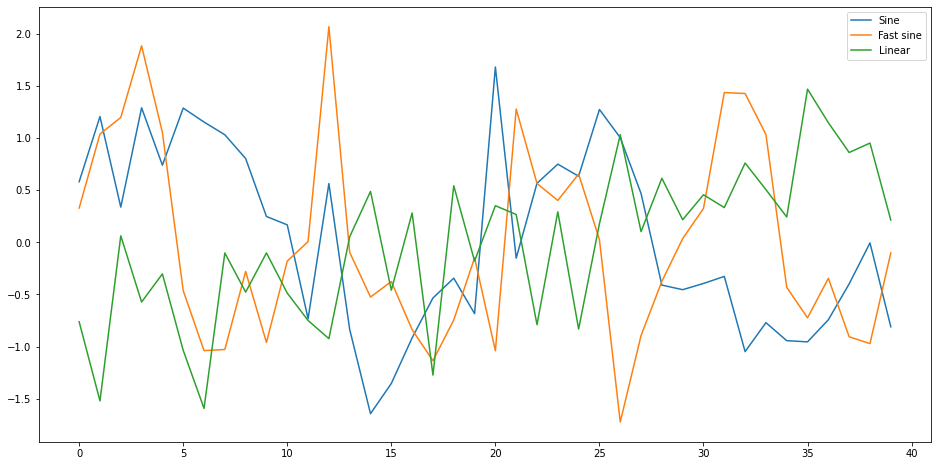

In [19]:
sigma = .5
xs = np.linspace(-1, 1, 40).reshape((1, 40)).repeat(32, axis=0)
sines = np.sin(2*np.pi*xs) + np.random.normal(0, sigma, size=(32, 40))
fsines = np.sin(4*np.pi*xs) + np.random.normal(0, sigma, size=(32, 40))
trends = xs + np.random.normal(0, sigma, size=(32, 40))

# randata = np.concatenate((sines, trends), axis=0)
plt.plot(sines[2], label="Sine")
plt.plot(fsines[2], label="Fast sine")
plt.plot(trends[2], label="Linear")
plt.legend();

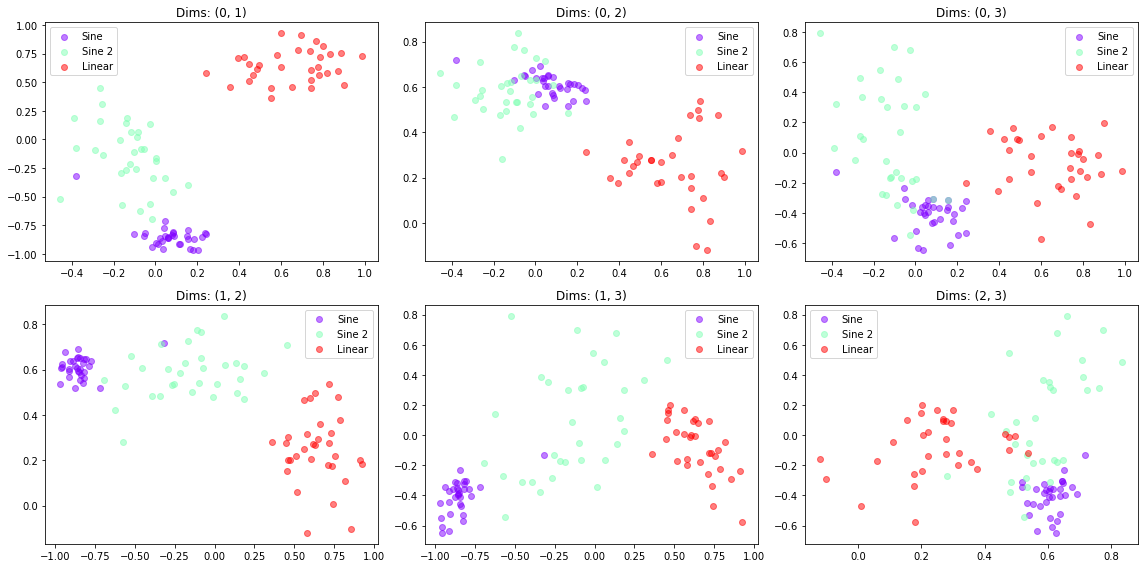

In [132]:
model, val_loader = load_model(config=config)

encoder = model.eval().encoder

series = {
    "Sine": sines,
    "Sine 2": fsines,
    "Linear": trends,
}
plot_embeddings(series)


In [148]:
import matplotlib.cm as cm


def get_embedding(s):
    return encoder(torch.Tensor(s).unsqueeze(2)).detach().squeeze(1).transpose(0, 1)

def plot_embeddings(series, pca=False):
    """
    For plotting classes in different dimensions of embedding vectors
    for a model with embedding vectors of length 4
    """
    fig, (axs1, axs2) = plt.subplots(nrows=2, ncols=3)
    axs = tuple(axs1) + tuple(axs2)
    dims = ((0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3))
    cs = cm.rainbow(np.linspace(0, 1, len(series)))

    embeddings = {n: get_embedding(s) for n, s in series.items()}
    
    if pca:
        all_ = np.concatenate(list(embeddings.values()), axis=1).transpose()
        pca = PCA(n_components=4).fit(all_)
        embeddings = {n: pca.transform(x.transpose(1, 0)).transpose(1, 0) for n, x in embeddings.items()}

    for ax, dim in zip(axs, dims):
        for (n, em), c in zip(embeddings.items(), cs):
            ax.scatter(*em[dim, :], color=c, label=n, alpha=.5)
        ax.legend()
        ax.set_title(f"Dims: {dim}")

    plt.tight_layout()
    plt.show()

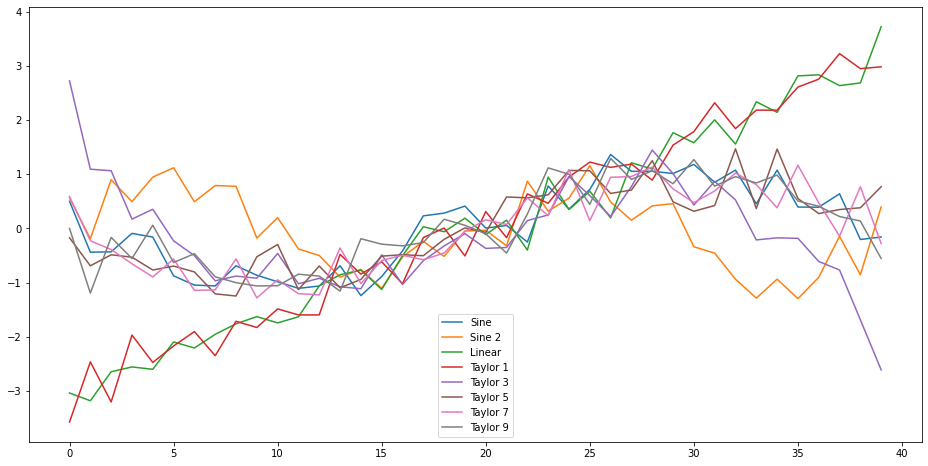

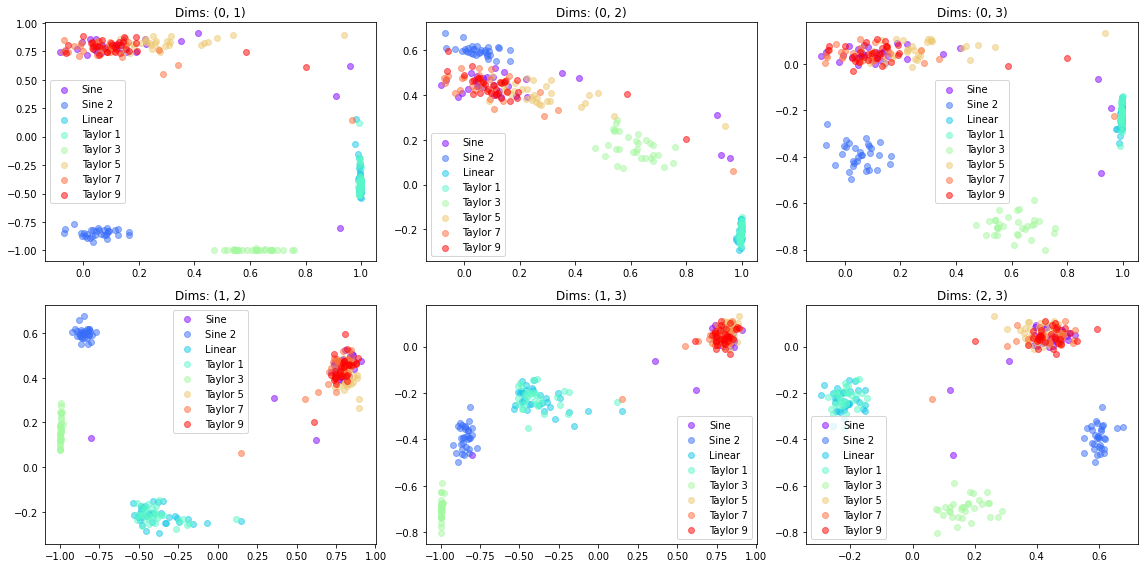

all (256, 4)
series (40, 32)
before pca torch.Size([4, 32])
after pca (4, 32)
after pca T (32, 4)


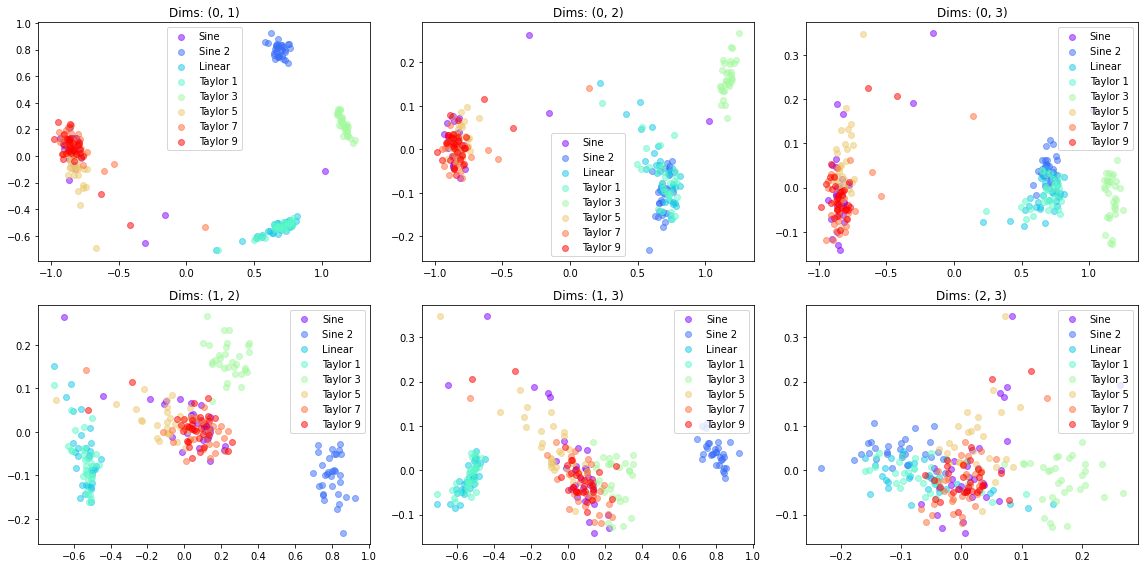

In [150]:
from scipy.interpolate import approximate_taylor_polynomial

sig = 0.3
n = 32

x = np.linspace(-1*np.pi, 1*np.pi, 40).reshape((1, 40)).repeat(n, axis=0)

series = {
    "Sine": np.sin(x) + np.random.normal(0, sig, size=(n, 40)),
    # "Sine pure": np.sin(x),
    "Sine 2": np.sin(2*x) + np.random.normal(0, sig, size=(n, 40)),
    "Linear": x + np.random.normal(0, sig, size=(n, 40)),
}

for deg in range(1, 11, 2):
    tp = approximate_taylor_polynomial(np.sin, 0, deg, 1, deg+2)
    series[f"Taylor {deg}"] = tp(x) + np.random.normal(0, sig, size=(n, 40))


for n, s in series.items():
    plt.plot(s[0], label=n)
plt.legend()

plot_embeddings(series, pca=False)
plot_embeddings(series, pca=True)

## Run training

### Define training initialization function

In [ ]:
def train(config=None, project=None, entity=None):
    with wandb.init(config=config, project=project, entity=entity, job_type="training", mode="disabled") as run:
        conf = wandb.config

        (train_loader,
         val_loader,
         seq_len,
         n_features) = get_dataloaders(run)

        model = RecurrentAutoencoder(
            seq_len=seq_len,
            n_features=n_features,
            embedding_dim=conf.embedding_dim,
            hidden_dim=conf.hidden_dim,
            dropout1=conf.dropout1,
            dropout2=conf.dropout2,
        )
        print(f"Moving model to device: {device}")
        model = model.to(device)

        model = train_model(
            model,
            train_loader,
            val_loader,
            conf=conf,
        )
    return model
    

### Standalone training

In [ ]:
config = dict(
    epochs=1,
    n_series=1_000,
    embedding_dim=16,
    hidden_dim=128,
    learning_rate=1e-3,
    dataartifact="m4-month-40:latest",
    architecture="LSTM-1-dropout",
    batch_size=256,
    optimizer="adamw",
    dropout1=0.5,
    dropout2=0.5,
)

In [ ]:
model = train(config=config, project="lstm-vae", entity="krankile")

FileNotFoundError: ignored

### As part of a sweep

In [ ]:
count = 50 # number of runs to execute
wandb.agent("krankile/lstm-vae/6ey4ngxs", function=train, count=count)

## Check results

In [ ]:
filepath = f"modelsaves/model-{conf.dataset}.torch"
print(filepath)
model.load_state_dict(torch.load(filepath))

model = model.eval().cpu()

In [ ]:
series = 2

for n, i in enumerate(range(0, series), start=1):
    plt.plot(np.linspace(0, 1, 100), train_tensor[i], label=f"Original {n}");
    plt.plot(
        np.linspace(0, 1, 100),
        model(train_tensor[i]).reshape((-1)).detach().numpy(),
        label=f"Reconstructed {n}",
        linestyle="-."
    )
plt.legend();

# Archive

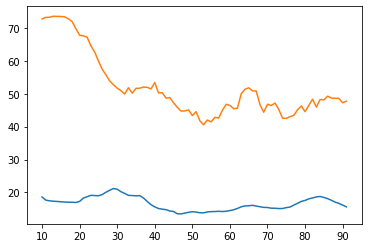

In [ ]:
# Plot training data
logspath = "/content/drive/MyDrive/# 9. Semester/Prosjektoppgave_runs-logs-2021-10-20 15:58:18.177512"

logs = pd.read_csv(logspath, sep=";").set_index("Epoch")
logs["tloss_smooth"] = logs["Train_loss"].rolling(10).mean()
logs["vloss_smooth"] = logs["Val_loss"].rolling(10).mean()
plt.plot(logs["tloss_smooth"]);
plt.plot(logs["vloss_smooth"]);

In [ ]:
# Not used in a sweep
config = dict(
    epochs=75,
    n_series=8000,
    embedding_dim=128,
    hidden_dim=256,
    learning_rate=1e-3,
    dataset="droso-3class-noise-v01",
    dataclass="droso-3class-noise",
    architecture="LSTM",
    batch_size=100,
    optimizer="adamw",
)

In [ ]:
columnlist = ['step',
 'step__MIN',
 'step__MAX',
 'train_loss',
 'train_loss__MIN',
 'train_loss__MAX',
 'val_loss',
 'val_loss__MIN',
 'val_loss__MAX']
tdf = pd.read_csv("/content/wandb_export_1.csv").set_index("epoch")
tdf.columns = columnlist

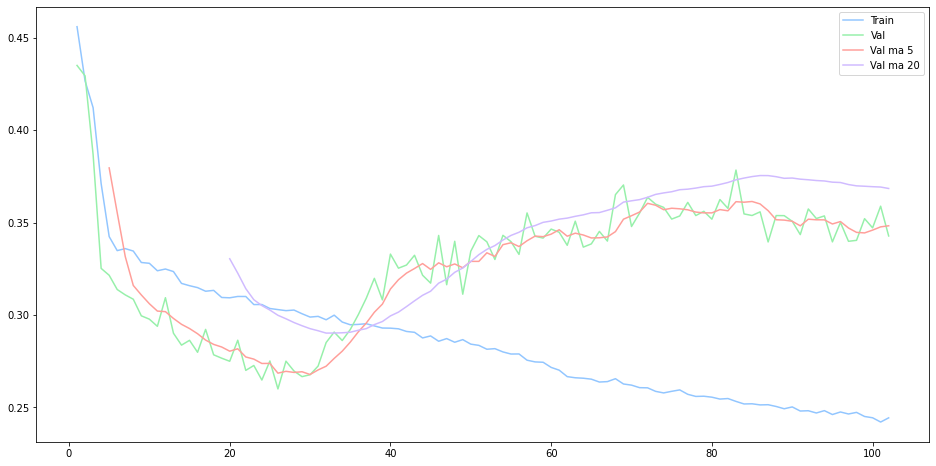

In [ ]:
ma1 = 5
ma2 = 20

tdf[f"val_ma{ma1}"] = tdf["val_loss"].rolling(window=ma1).mean()
tdf[f"val_ma{ma2}"] = tdf["val_loss"].rolling(window=ma2).mean()*1.05

plt.plot(tdf["train_loss"], label="Train")
plt.plot(tdf["val_loss"], label="Val")
plt.plot(tdf[f"val_ma{ma1}"], label=f"Val ma {ma1}")
plt.plot(tdf[f"val_ma{ma2}"], label=f"Val ma {ma2}")
plt.legend();